### Benchmark: `TTim` validation of tidal response with analytic solutions

This notebook shows some validation of tidal wave propagation in a ModelXsection against known formulas from literature (Bruggeman, 1999: `Analytical solutions of geohydrological problems`).

Three situations are shown:
1. Bruggeman 128.01: tidal fluctation of open water, in a confined aquifer with open boundary at x=0
2. Bruggeman 128.03: tidal fluctation of open water, in a leaky aquifer with open boundary at x=0
3. Bruggeman 128.04: tidal fluctation of open water, in a leaky aquifer with entry resistance at x=0

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ttim

Here we define some solutions from the book of Bruggeman. 

_(Note 1: Note how easily `numpy` deals with the complex algebra (splitting into an imaginary and a real part)._

_(Note 2: We might move the Bruggeman code to a new repository: https://github.com/dbrakenhoff/bruggeman)._

In [2]:
def bruggeman_128_01(x, t, h, S, k, D, tau):
    """Tidal fluctuation open water, confined aquifer with open boundary (x = 0).

    From Bruggeman 128.01

    h = amplitude of tidal fluctuation, [m]
    k = hydraulic conductivity [m/d]
    D = aquifer thickness [m]
    S = storage coefficient [-]
    tau = tidal period [d]
    """
    beta = np.sqrt(S / (k * D))
    omega = 2 * np.pi / tau
    omega_accent = beta * np.sqrt(omega / 2)

    return h * np.exp(-omega_accent * x) * np.sin(omega * t - omega_accent * x)


def bruggeman_128_03(x, t, h, S, k, D, tau, c):
    """Tidal fluctuation open water, leaky aquifer with open boundary (x = 0).

    From Bruggeman 128.03

    h = amplitude of tidal fluctuation, [m]
    k = hydraulic conductivity [m/d]
    D = aquifer thickness [m]
    S = storage coefficient [-]
    tau = tidal period [d]
    c = leakance [d]
    """
    beta = np.sqrt(S / (k * D))
    eta = 1 / (c * S)
    omega = 2 * np.pi / tau

    a = np.real(np.sqrt(eta + 1j * omega))
    b = np.imag(np.sqrt(eta + 1j * omega))

    return h * np.exp(-beta * a * x) * np.sin(omega * t - beta * b * x)


def bruggeman_128_04(x, t, h, S, k, D, tau, c, w):
    """Tidal fluctuation open water, leaky aquifer with entrance resistance (x = 0).

    From Bruggeman 128.04

    h = amplitude of tidal fluctuation, [m]
    k = hydraulic conductivity [m/d]
    D = aquifer thickness [m]
    S = storage coefficient [-]
    tau = tidal period [d]
    c = leakance [d]
    w = entry resistance at x=0 [d]
    """
    beta = np.sqrt(S / (k * D))
    eta = 1 / (c * S)
    omega = 2 * np.pi / tau
    theta = 1 / (np.power(beta, 2) * np.power(k, 2) * np.power(w, 2))

    a = np.real(np.sqrt(eta + 1j * omega))
    b = np.imag(np.sqrt(eta + 1j * omega))

    return (
        h
        * np.sqrt(theta)
        * np.exp(-beta * a * x)
        * np.sin(omega * t - beta * b * x - np.arctan(b / (a + np.sqrt(theta))))
        / (np.sqrt(np.power((a + np.sqrt(theta)), 2) + np.power(b, 2)))
    )

The analytic solution is for a river with varying head that has been varying for ever. 
In `ttim`, head is simulated for several days to get the model to spin-up. 

By using a `sine` function, the head starts at zero (as should be the case in TTim).

In [3]:
def head_river(h, t, tau, tp=0):
    return h * np.sin(2 * np.pi * (t - tp) / tau)

Below the `sine` (water level on river) is split into steps as shown in the example [How to model a fluctuating head boundary](https://ttim.readthedocs.io/en/latest/00tutorials/howto_fluctuating_head_boundary.html). We use a small timestep ($\Delta t$)

In [4]:
# Parameters of tidal wave
tau = 0.5  # tidal period, d
h_tidal = 1  # amplitude of tidal fluctuation, m

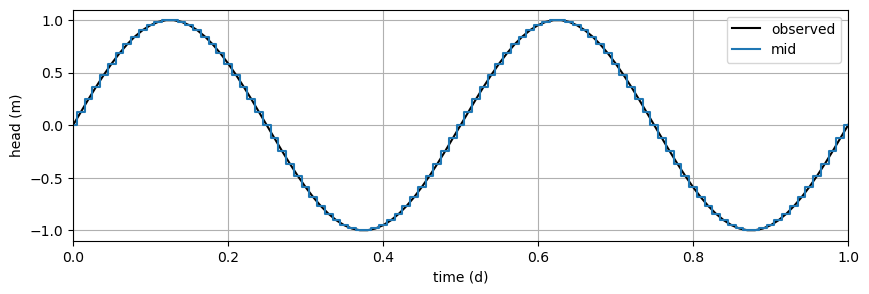

In [5]:
tmax = 5  # day
delt = 0.01  # day
t = np.arange(0, tmax, delt)
hexact = head_river(h_tidal, t, tau)
hmid = 0.5 * (
    head_river(h_tidal, t - delt / 2, tau) + head_river(h_tidal, t + delt / 2, tau)
)
tmid = np.hstack((0, 0.5 * (t[:-1] + t[1:])))
# plot
plt.figure(figsize=(10, 3))
plt.plot(t, hexact, "k", label="observed")
plt.step(tmid, hmid, where="post", label="mid")
plt.xlim(0, 1)
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()

#### Bruggeman 128.01 - Confined, no entry resistance

Create the TTim model for comparison with Bruggeman 128.01 (confined, no entry resistance).

In this example, we use the 1D inhomogeneities because of the nice plotting. The same result could be reached with a 'normal' TTim model.
In all the TTim models, the left-hand inhomogeneity (`river`) is shown for illustration purposes. That inhomogeneity is only created to satisfy the requirement of ModelXsection to have inhoms for  $-\infty<x<\infty$.

The hydraulic boundary `river_hls` is modeled as a HeadLineSink1D at x=0.

In [6]:
# parameters
k = 20.0  # hydraulic conductivity, m/d
H = 50.0  # thickness of aquifer, m
T = k * H  # transmissivity, m^2/d
S = 0.001  # storage coefficient of aquifer, [-]

Saq = S / H  # specific storage [1/m]

self.neq  3
solution complete


(-52.5, 12.0)

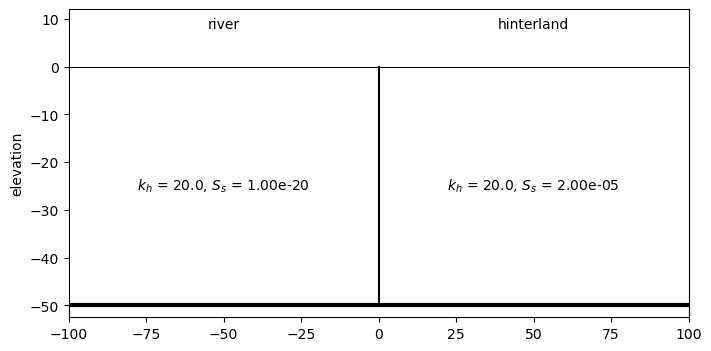

In [7]:
ml = ttim.ModelXsection(naq=1, tmin=1e-4, tmax=1e2)

riv = ttim.XsectionMaq(
    model=ml,
    x1=-np.inf,
    x2=0,
    kaq=k,
    z=[0, -H],
    Saq=1e-20,
    Sll=1e-20,
    topboundary="confined",
    phreatictop=False,
    name="river",
)

land = ttim.XsectionMaq(
    model=ml,
    x1=0,
    x2=np.inf,
    kaq=k,
    z=[0, -H],
    Saq=Saq,
    topboundary="confined",
    phreatictop=False,
    name="hinterland",
)

# Use a small offset to avoid a singular matrix.
small = 1e-5

river_hls = ttim.HeadLineSink1D(
    model=ml, xls=0 - small, tsandh=list(zip(tmid, hmid, strict=True))
)


ml.solve()

ax = riv.plot(params=True, names=True, labels=False)
land.plot(ax=ax, params=True, names=True, labels=False)
river_hls.plot(ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(ymax=12)

Let's compare the head at several locations.

As can be seen from the lowest graph $x = 500$, the `TTim` model needs some spinup time, but after a few days the graphs are similar.

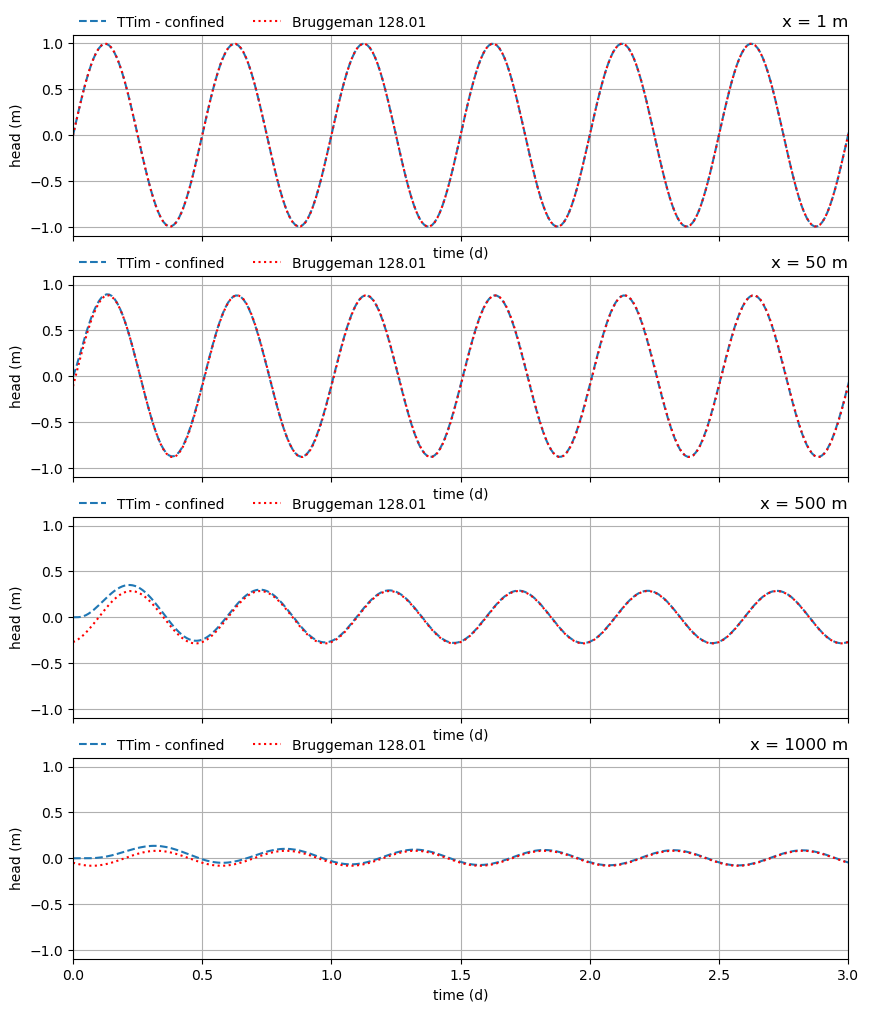

In [8]:
xlocs = [1, 50, 500, 1000]
tp = t

f, axes = plt.subplots(
    len(xlocs), 1, figsize=(10, 3 * len(xlocs)), sharex=True, sharey=True
)

for i in range(len(xlocs)):
    h = ml.head(xlocs[i], 0, tp)
    axes[i].plot(tp, h[0], label="TTim - confined", linestyle="--")

    h_128_01 = bruggeman_128_01(xlocs[i], tp, h_tidal, S, k, H, tau)
    axes[i].plot(tp, h_128_01, "r", label="Bruggeman 128.01", linestyle=":")

    axes[i].set_title(f"x = {xlocs[i]} m", loc="right")
    axes[i].legend(loc=(0, 1), frameon=False, ncol=2)
    axes[i].grid()
    axes[i].set_xlabel("time (d)")
    axes[i].set_ylabel("head (m)")
    axes[i].set_xlim([0, 3])

#### Bruggeman 128.03 Leaky, no entry resistance

Create a TTim model for comparison with Bruggeman 128.03 (leaky, no entry resistance).

self.neq  3
solution complete


(-52.75, 12.0)

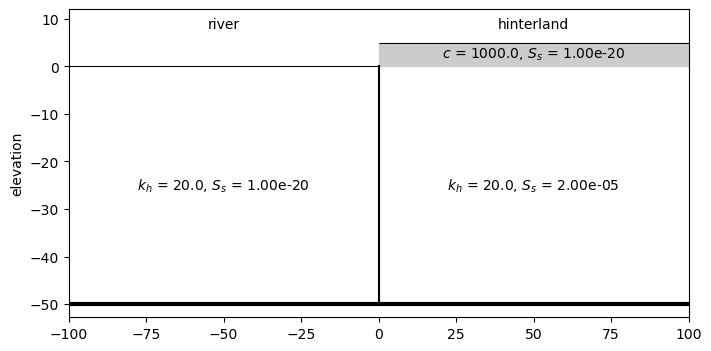

In [9]:
# Additional parameters for this model:
c = 1000  # leakage factor, d

# The model
ml2 = ttim.ModelXsection(naq=1, tmin=1e-4, tmax=1e2)

riv2 = ttim.XsectionMaq(
    model=ml2,
    x1=-np.inf,
    x2=0,
    kaq=k,
    z=[0, -H],
    Saq=1e-20,
    Sll=1e-20,
    topboundary="confined",
    phreatictop=False,
    name="river",
)

land2 = ttim.XsectionMaq(
    model=ml2,
    x1=0,
    x2=np.inf,
    kaq=k,
    z=[5, 0, -H],
    c=c,
    Saq=Saq,
    topboundary="semi",
    phreatictop=False,
    name="hinterland",
)

# Use a small offset to avoid a singular matrix.
small = 1e-5

river_hls2 = ttim.HeadLineSink1D(
    model=ml2, xls=0 - small, tsandh=list(zip(tmid, hmid, strict=True))
)


ml2.solve()

ax = riv2.plot(params=True, names=True, labels=False)
land2.plot(ax=ax, params=True, names=True, labels=False)
river_hls2.plot(ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(ymax=12)

Again, compare heads at several locations.

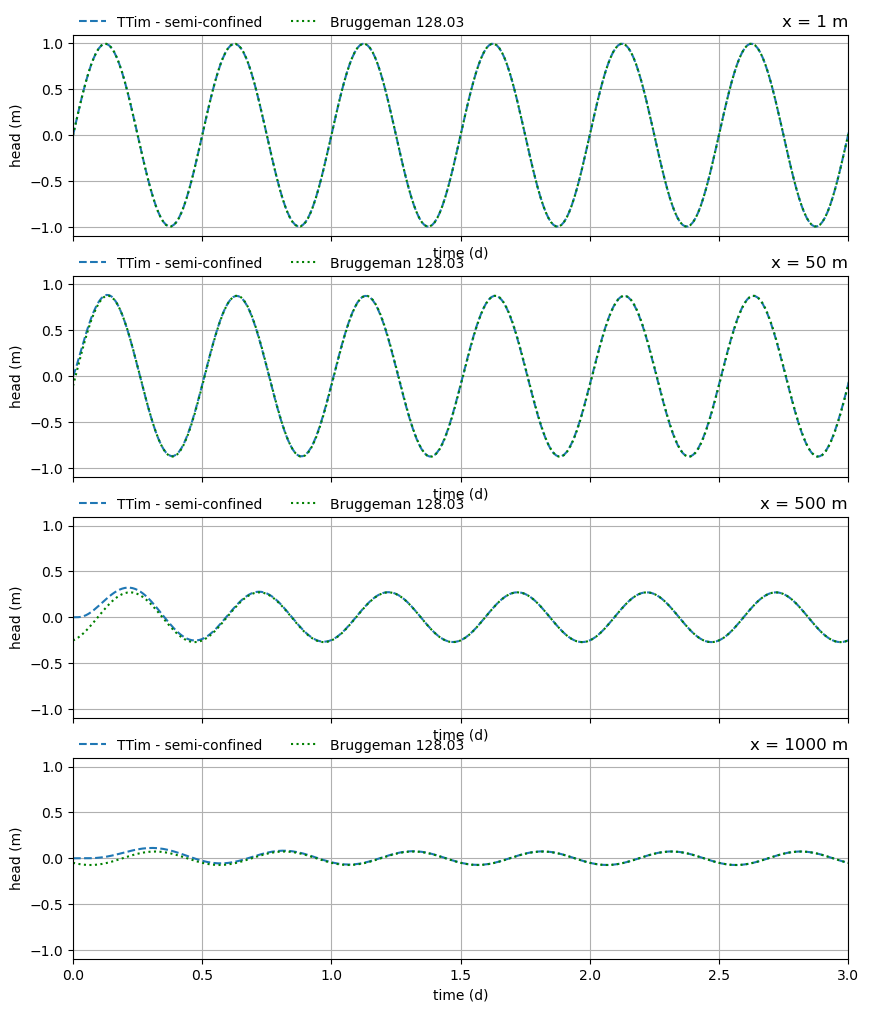

In [10]:
xlocs = [1, 50, 500, 1000]
tp = t

f, axes = plt.subplots(
    len(xlocs), 1, figsize=(10, 3 * len(xlocs)), sharex=True, sharey=True
)

for i in range(len(xlocs)):
    h = ml2.head(xlocs[i], 0, tp)
    axes[i].plot(tp, h[0], label="TTim - semi-confined", linestyle="--")

    h_128_03 = bruggeman_128_03(xlocs[i], tp, h_tidal, S, k, H, tau, c)
    axes[i].plot(tp, h_128_03, "g", label="Bruggeman 128.03", linestyle=":")

    axes[i].set_title(f"x = {xlocs[i]} m", loc="right")
    axes[i].legend(loc=(0, 1), frameon=False, ncol=2)
    axes[i].grid()
    axes[i].set_xlabel("time (d)")
    axes[i].set_ylabel("head (m)")
    axes[i].set_xlim([0, 3])

#### Bruggeman 128.04 Leaky, with entry resistance

Create a TTim model for comparison with Bruggeman 128.04 (leaky, with entry resistance at x=0). 

The entry resistance is added to the HeadLineSink1D `river_hls` by adding the keyword argument `res=w`.

self.neq  3
solution complete


(-52.75, 12.0)

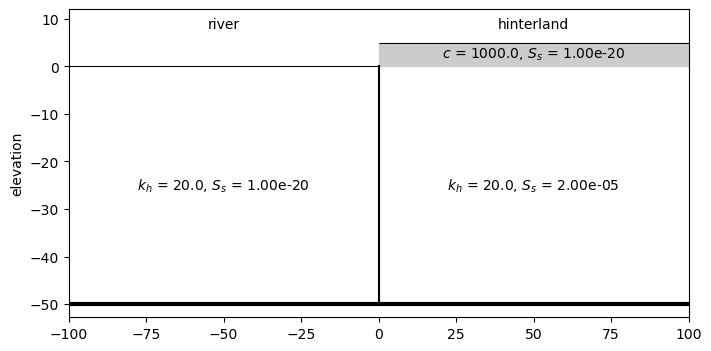

In [11]:
# Additional parameters for this model:
w = 20  # entry resistance at x=0, d

# The model
ml3 = ttim.ModelXsection(naq=1, tmin=1e-4, tmax=1e2)

riv3 = ttim.XsectionMaq(
    model=ml3,
    x1=-np.inf,
    x2=0,
    kaq=k,
    z=[0, -H],
    Saq=1e-20,
    Sll=1e-20,
    topboundary="confined",
    phreatictop=False,
    name="river",
)

land3 = ttim.XsectionMaq(
    model=ml3,
    x1=0,
    x2=np.inf,
    kaq=k,
    z=[5, 0, -H],
    c=c,
    Saq=Saq,
    topboundary="semi",
    phreatictop=False,
    name="hinterland",
)


# Use a small offset to avoid a singular matrix.
small = 1e-5

river_hls3 = ttim.HeadLineSink1D(
    model=ml3,
    xls=0 - small,
    tsandh=list(zip(tmid, hmid, strict=True)),
    res=w,
)

ml3.solve()

ax = riv3.plot(params=True, names=True, labels=False)
land3.plot(ax=ax, params=True, names=True, labels=False)
river_hls3.plot(ax=ax)

ax.set_xlim(-100, 100)
ax.set_ylim(ymax=12)

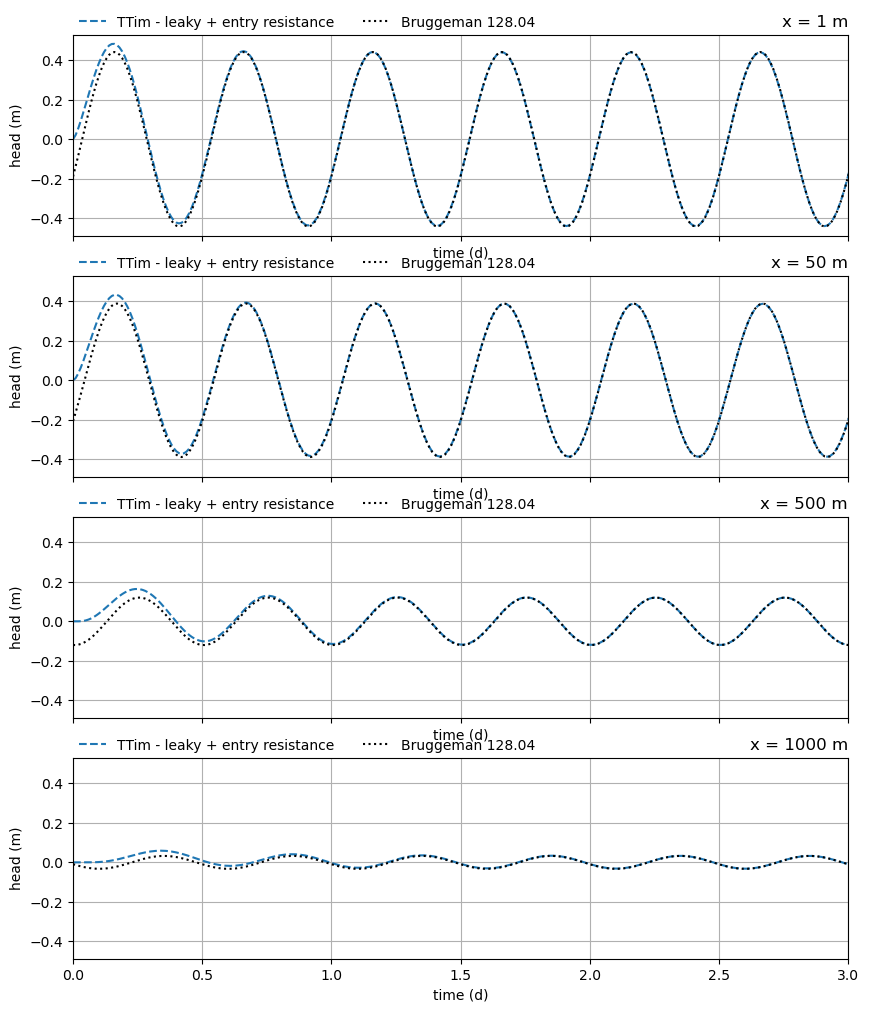

In [12]:
xlocs = [1, 50, 500, 1000]
tp = t

f, axes = plt.subplots(
    len(xlocs), 1, figsize=(10, 3 * len(xlocs)), sharex=True, sharey=True
)

for i in range(len(xlocs)):
    h = ml3.head(xlocs[i], 0, tp)
    axes[i].plot(tp, h[0], label="TTim - leaky + entry resistance", linestyle="--")
    h_128_04 = bruggeman_128_04(xlocs[i], tp, h_tidal, S, k, H, tau, c, w)
    axes[i].plot(tp, h_128_04, "k", label="Bruggeman 128.04", linestyle=":")
    axes[i].set_title(f"x = {xlocs[i]} m", loc="right")
    axes[i].legend(loc=(0, 1), frameon=False, ncol=2)
    axes[i].grid()
    axes[i].set_xlabel("time (d)")
    axes[i].set_ylabel("head (m)")
    axes[i].set_xlim([0, 3])

As can be seen, all three cases are replicated accurately after approximately 2 days spinup time.

In the case with entry resistance, the head in the aquifer is already considerably damped compared to the open water fluctuation, even at a small distance (x=1 m).